<center><h1 style="background-color: #C6F3CD; border-radius: 10px; color: #FFFFFF; padding: 5px;">
Production function and Cost function
</h1><center/>

**Link to the article** : https://medium.com/kinomoto-mag/the-ultimate-guide-to-production-functions-and-cost-management-with-python-e6ff8085c147?sk=c561d517b7c6918d4465c510f8d5d54e

In [9]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.optimize import minimize

<center><h1 style="background-color: #C6F3CD; border-radius: 10px; color: #FFFFFF; padding: 5px;">
Create the Dataframe
</h1><center/>

In [3]:
data = {
    'Year': [1, 2, 3, 4],
    'Output': [100, 150, 200, 250],
    'Labor_Hours': [400000, 420000, 440000, 460000],
    'Capital_Investment': [400000, 420000, 440000, 460000]
}

# Create a DataFrame
df = pd.DataFrame(data)
df

,Year,Output,Labor_Hours,Capital_Investment
0,1,100,400000,400000
1,2,150,420000,420000
2,3,200,440000,440000
3,4,250,460000,460000


<center><h1 style="background-color: #C6F3CD; border-radius: 10px; color: #FFFFFF; padding: 5px;">
Log Transformation
</h1><center/>

In [5]:
# Step 2: Logarithmic transformation
df['log_output'] = np.log(df['Output'])
df['log_labor'] = np.log(df['Labor_Hours'])
df['log_capital'] = np.log(df['Capital_Investment'])

# Display the data after logarithmic transformation
df

,Year,Output,Labor_Hours,Capital_Investment,log_output,log_labor,log_capital
0,1,100,400000,400000,4.605170,12.899220,12.899220
1,2,150,420000,420000,5.010635,12.948010,12.948010
2,3,200,440000,440000,5.298317,12.994530,12.994530
3,4,250,460000,460000,5.521461,13.038982,13.038982


<center><h1 style="background-color: #C6F3CD; border-radius: 10px; color: #FFFFFF; padding: 5px;">
Estimate the coefficients
</h1><center/>

In [13]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit Elastic Net model
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)  # alpha is the regularization strength, l1_ratio balances between L1 and L2
elastic_net.fit(X_scaled, y)

# Print coefficients
print('Intercept:', elastic_net.intercept_)
print('Coefficients:', elastic_net.coef_)

Intercept: 5.108895941123658
Coefficients: [0.14177856 0.14152051]


In [14]:
def compute_output(TFP, labor, capital, alpha, beta):
    log_labor = np.log(labor)
    log_capital = np.log(capital)
    output = TFP * (labor ** alpha) * (capital ** beta)
    return output

# Given values from regression
TFP = np.exp(5.1089)
alpha = 0.1418
beta = 0.1415

# Example data for Year 1
labor = 8000
capital = 150000

# Compute output
output = compute_output(TFP, labor, capital, alpha, beta)
print(f"Output for Year 1: {output:.2f}")

Output for Year 1: 3196.26


In [17]:
# Example data for other years
labor_years = [8000, 8500, 9000, 9500]
capital_years = [150000, 155000, 160000, 165000]

outputs = [compute_output(TFP, labor, capital, alpha, beta) for labor, capital in zip(labor_years, capital_years)]

# Compute marginal returns for each year
marginal_returns = [outputs[i] - outputs[i-1] for i in range(1, len(outputs))]

# Print the results
for i, output in enumerate(outputs):
    if i == 0:
        print(f"Output for Year {i+1}: {output:.2f}")
    else:
        print(f"Output for Year {i+1}: {output:.2f} (Marginal Return: {marginal_returns[i-1]:.2f})")

Output for Year 1: 3196.26
Output for Year 2: 3238.85 (Marginal Return: 42.59)
Output for Year 3: 3279.91 (Marginal Return: 41.06)
Output for Year 4: 3319.57 (Marginal Return: 39.67)


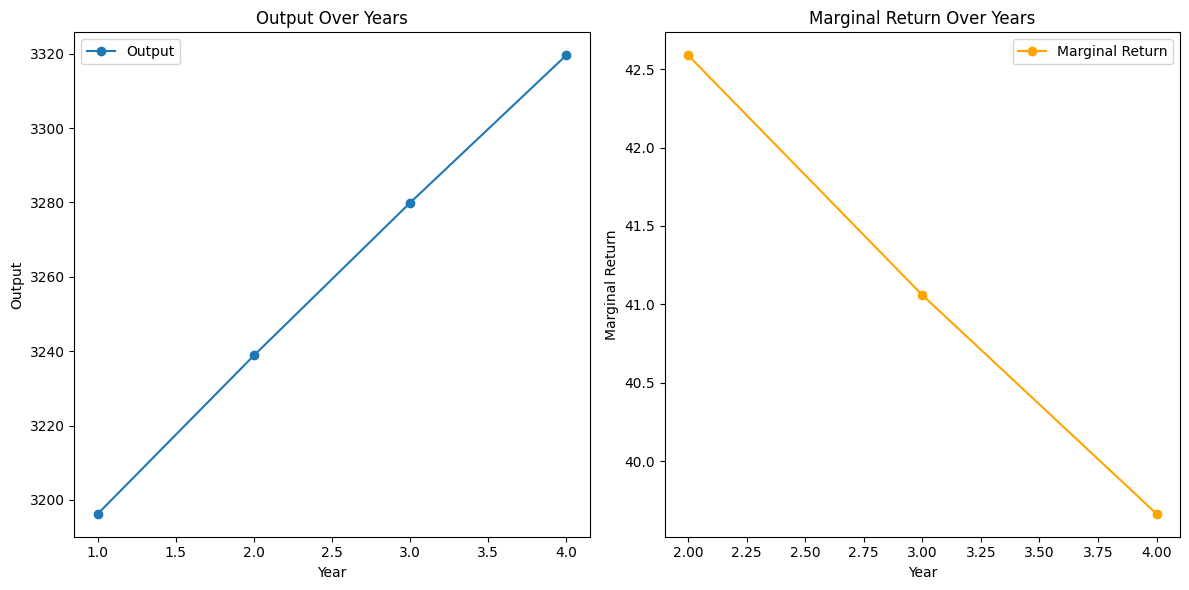

In [20]:
# Visualization
years = np.arange(1, len(outputs) + 1)

plt.figure(figsize=(12, 6))

# Plot outputs
plt.subplot(1, 2, 1)
plt.plot(years, outputs, marker='o', label='Output')
plt.xlabel('Year')
plt.ylabel('Output')
plt.title('Output Over Years')
plt.legend()

# Plot marginal returns
plt.subplot(1, 2, 2)
plt.plot(years[1:], marginal_returns, marker='o', label='Marginal Return', color='orange')
plt.xlabel('Year')
plt.ylabel('Marginal Return')
plt.title('Marginal Return Over Years')
plt.legend()

plt.tight_layout()
plt.show()

<center><h1 style="background-color: #C6F3CD; border-radius: 10px; color: #FFFFFF; padding: 5px;">
Full Function
</h1><center/>

In [23]:
def production_analysis(labor_years, capital_years, outputs):
    # Step 1: Prepare the data
    data = pd.DataFrame({
        'labor': labor_years,
        'capital': capital_years,
        'output': outputs
    })
    
    # Step 2: Log-transform the data
    data['log_labor'] = np.log(data['labor'])
    data['log_capital'] = np.log(data['capital'])
    data['log_output'] = np.log(data['output'])

    # Step 3: Scale the data
    scaler = StandardScaler()
    X = scaler.fit_transform(data[['log_labor', 'log_capital']])
    y = data['log_output']

    # Step 4: Fit ElasticNetCV model to find best alpha and l1_ratio
    try:
        model = ElasticNetCV(cv=3)  # Using 3-fold cross-validation
        model.fit(X, y)
    except ValueError as e:
        print(f"Error in model fitting: {e}")
        return

    # Get the coefficients
    alpha = model.coef_[0]
    beta = model.coef_[1]
    intercept = model.intercept_
    tfp = np.exp(intercept)

    # Step 5: Compute the production function for given labor and capital values
    def compute_output(TFP, labor, capital, alpha, beta):
        return TFP * (labor ** alpha) * (capital ** beta)

    outputs = [compute_output(tfp, labor, capital, alpha, beta) for labor, capital in zip(labor_years, capital_years)]

    # Compute marginal returns
    marginal_returns = [outputs[i] - outputs[i-1] for i in range(1, len(outputs))]

    # Print the results
    for i, output in enumerate(outputs):
        if i == 0:
            print(f"Output for Year {i+1}: {output:.2f}")
        else:
            print(f"Output for Year {i+1}: {output:.2f} (Marginal Return: {marginal_returns[i-1]:.2f})")

    # Visualization
    years = np.arange(1, len(outputs) + 1)

    plt.figure(figsize=(12, 6))

    # Plot outputs
    plt.subplot(1, 2, 1)
    plt.plot(years, outputs, marker='o', label='Output')
    plt.xlabel('Year')
    plt.ylabel('Output')
    plt.title('Output Over Years')
    plt.legend()

    # Plot marginal returns
    plt.subplot(1, 2, 2)
    plt.plot(years[1:], marginal_returns, marker='o', label='Marginal Return', color='orange')
    plt.xlabel('Year')
    plt.ylabel('Marginal Return')
    plt.title('Marginal Return Over Years')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Analysis
    print("\nAnalysis:")
    print(f"Total Factor Productivity (TFP): {tfp:.2f}")
    if alpha > beta:
        print(f"The impact of labor on production is higher than that of capital. (alpha = {alpha:.4f}, beta = {beta:.4f})")
    else:
        print(f"The impact of capital on production is higher than that of labor. (alpha = {alpha:.4f}, beta = {beta:.4f})")

Output for Year 1: 220461.66
Output for Year 2: 227411.70 (Marginal Return: 6950.04)
Output for Year 3: 234164.92 (Marginal Return: 6753.22)
Output for Year 4: 240737.38 (Marginal Return: 6572.47)


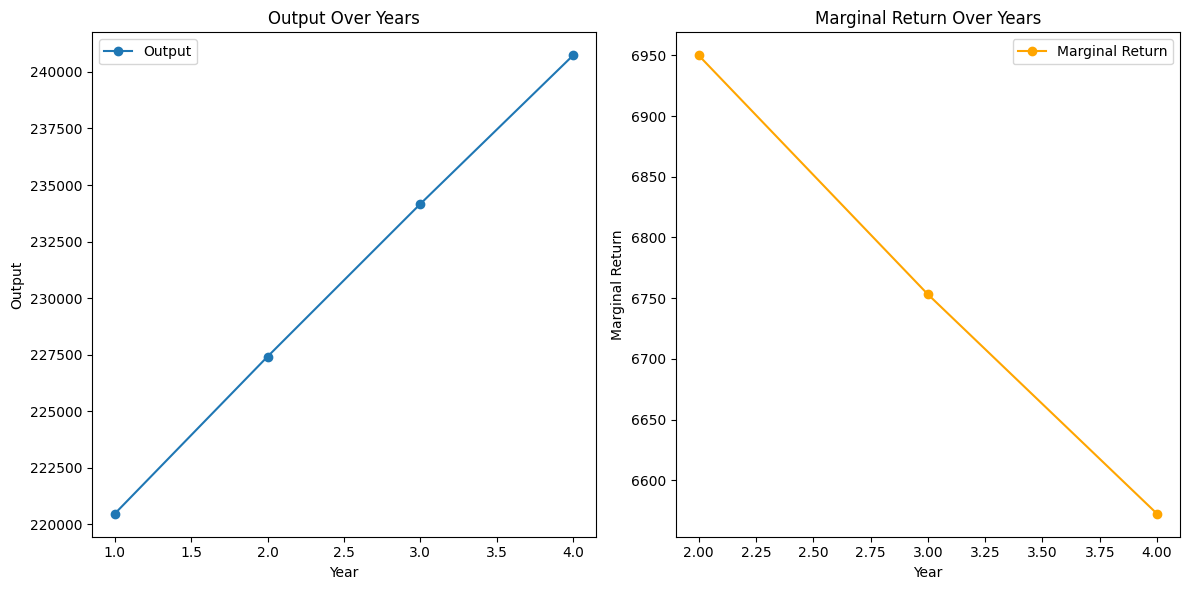


Analysis:
Total Factor Productivity (TFP): 2213.36
The impact of labor on production is higher than that of capital. (alpha = 0.5120, beta = -0.0000)


In [24]:
# Example usage

labor_years = [8000, 8500, 9000, 9500]
capital_years = [150000, 155000, 160000, 165000]
outputs = [1000, 2000, 3000, 4000]  # Replace with your actual output data

production_analysis(labor_years, capital_years, outputs)

<center><h1 style="background-color: #C6F3CD; border-radius: 10px; color: #FFFFFF; padding: 5px;">
Full Function with cost function
</h1><center/>

In [26]:
def production_analysis(labor_years, capital_years, outputs, wage_rate, rental_rate, desired_output):
    # Step 1: Prepare the data
    data = pd.DataFrame({
        'labor': labor_years,
        'capital': capital_years,
        'output': outputs
    })
    
    # Step 2: Log-transform the data
    data['log_labor'] = np.log(data['labor'])
    data['log_capital'] = np.log(data['capital'])
    data['log_output'] = np.log(data['output'])

    # Step 3: Scale the data
    scaler = StandardScaler()
    X = scaler.fit_transform(data[['log_labor', 'log_capital']])
    y = data['log_output']

    # Step 4: Fit ElasticNetCV model to find best alpha and l1_ratio
    model = ElasticNetCV(cv=3)  # Using 3-fold cross-validation
    model.fit(X, y)

    # Get the coefficients
    alpha = model.coef_[0]
    beta = model.coef_[1]
    intercept = model.intercept_
    tfp = np.exp(intercept)

    # Step 5: Compute the production function for given labor and capital values
    def compute_output(TFP, labor, capital, alpha, beta):
        return TFP * (labor ** alpha) * (capital ** beta)

    outputs = [compute_output(tfp, labor, capital, alpha, beta) for labor, capital in zip(labor_years, capital_years)]

    # Compute marginal returns
    marginal_returns = [outputs[i] - outputs[i-1] for i in range(1, len(outputs))]

    # Print the results
    for i, output in enumerate(outputs):
        if i == 0:
            print(f"Output for Year {i+1}: {output:.2f}")
        else:
            print(f"Output for Year {i+1}: {output:.2f} (Marginal Return: {marginal_returns[i-1]:.2f})")

    # Visualization
    years = np.arange(1, len(outputs) + 1)

    plt.figure(figsize=(12, 6))

    # Plot outputs
    plt.subplot(1, 2, 1)
    plt.plot(years, outputs, marker='o', label='Output')
    plt.xlabel('Year')
    plt.ylabel('Output')
    plt.title('Output Over Years')
    plt.legend()

    # Plot marginal returns
    plt.subplot(1, 2, 2)
    plt.plot(years[1:], marginal_returns, marker='o', label='Marginal Return', color='orange')
    plt.xlabel('Year')
    plt.ylabel('Marginal Return')
    plt.title('Marginal Return Over Years')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Analysis
    print("\nAnalysis:")
    print(f"Total Factor Productivity (TFP): {tfp:.2f}")
    if alpha > beta:
        print(f"The impact of labor on production is higher than that of capital. (alpha = {alpha:.4f}, beta = {beta:.4f})")
    else:
        print(f"The impact of capital on production is higher than that of labor. (alpha = {alpha:.4f}, beta = {beta:.4f})")

    # Least-cost combination of inputs
    def cost_function(x):
        L, K = x
        return wage_rate * L + rental_rate * K

    def production_constraint(x):
        L, K = x
        return tfp * (L ** alpha) * (K ** beta) - desired_output

    initial_guess = [1000, 1000]
    constraints = [{'type': 'eq', 'fun': production_constraint}]
    bounds = [(0, None), (0, None)]

    result = minimize(cost_function, initial_guess, method='SLSQP', constraints=constraints, bounds=bounds)
    optimal_L, optimal_K = result.x

    print(f"\nOptimal labor (L): {optimal_L:.2f}")
    print(f"Optimal capital (K): {optimal_K:.2f}")
    print(f"Minimum cost: {result.fun:.2f}")

Output for Year 1: 220461.66
Output for Year 2: 227411.70 (Marginal Return: 6950.04)
Output for Year 3: 234164.92 (Marginal Return: 6753.22)
Output for Year 4: 240737.38 (Marginal Return: 6572.47)


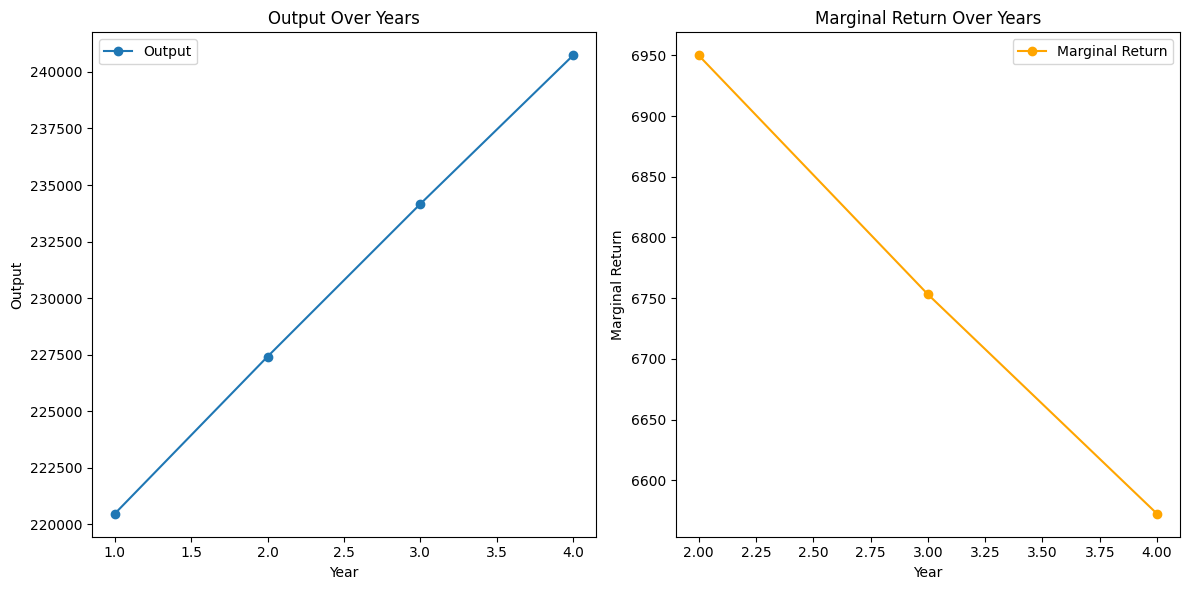


Analysis:
Total Factor Productivity (TFP): 2213.36
The impact of labor on production is higher than that of capital. (alpha = 0.5120, beta = -0.0000)

Optimal labor (L): 1.81
Optimal capital (K): 0.00
Minimum cost: 90.56


In [27]:
labor_years = [8000, 8500, 9000, 9500]
capital_years = [150000, 155000, 160000, 165000]
outputs = [1000, 2000, 3000, 4000]  
wage_rate = 50
rental_rate = 100
desired_output = 3000

production_analysis(labor_years, capital_years, outputs, wage_rate, rental_rate, desired_output)